In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

['gender_submission.csv', 'test.csv', 'train.csv']


In [2]:
def read_and_clean(file_name):
    scalers = []
    data_full = pd.read_csv(file_name)
    
    # parse names to extract title information
    dataset_title = [i.split(",")[1].split(".")[0].strip() for i in data_full["Name"]]
    data_full["Title"] = pd.Series(dataset_title)
    data_full["Title"] = data_full["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    data_full['FamilySize'] = data_full['SibSp'] + data_full['Parch'] + 1
    data_full.drop(['Name','SibSp','Parch','Ticket','Fare'], axis=1, inplace=True)    

    #cleanup
    age_mean = data_full['Age'].mean()
    # Replace the Cabin number by the type of cabin 'Z' if not
    values = {'Cabin':'Z','Embarked':'S','Age':age_mean}
    data_full.fillna(value=values,inplace=True)
    data_full['Cabin1'] = data_full['Cabin'].str[0]    
    data_full.drop(['Cabin'], axis=1, inplace=True)    
    
    #encode labels
    data_full['Sex'] = LabelEncoder().fit_transform(data_full['Sex'].values)
    data_full['Cabin1'] = LabelEncoder().fit_transform(data_full['Cabin1'].values)
    data_full['Embarked'] = LabelEncoder().fit_transform(data_full['Embarked'].values)
    data_full['Title'] = LabelEncoder().fit_transform(data_full['Title'].values)
        
    data_full.dropna(inplace=True)
    
    # Create new feature of family size
    data_full['Single'] = data_full['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    data_full['SmallF'] = data_full['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    data_full['MedF'] = data_full['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    data_full['LargeF'] = data_full['FamilySize'].map(lambda s: 1 if s >= 5 else 0)    
    
    return data_full

dataset = read_and_clean('../input/train.csv')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Title,FamilySize,Cabin1,Single,SmallF,MedF,LargeF
0,1,0,3,1,22.0,2,4,2,8,0,1,0,0
1,2,1,1,0,38.0,0,5,2,2,0,1,0,0
2,3,1,3,0,26.0,2,1,1,8,1,0,0,0
3,4,1,1,0,35.0,2,5,2,2,0,1,0,0
4,5,0,3,1,35.0,2,4,1,8,1,0,0,0


Text(0, 0.5, 'Frequency')

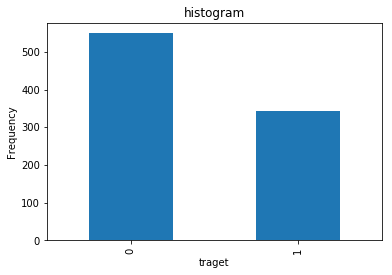

In [3]:
count_classes = pd.value_counts(dataset.Survived, sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("histogram")
plt.xlabel("traget")
plt.ylabel("Frequency")

In [4]:
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


# Convert target to categorical
#col = pd.Categorical(dataset.Survived)
#dataset["Survived"] = col.codes

class_weights = get_class_weights(dataset.Survived.values)
print(class_weights)

{0: 1.0, 1: 1.61}


In [5]:
def scale_dataset(dataset):
    scalers = {}
    for column in columns_to_scale:
        scaler = RobustScaler()
        dataset[column] = scaler.fit_transform(dataset[column].values.reshape(-1, 1))
        scalers[column] = scaler
    return dataset, scalers
    
    
working_columns = ['Pclass','Sex','Age', 'Embarked','FamilySize','Cabin1','Title', 'Single','SmallF','MedF','LargeF']
columns_to_scale = ['Age']

# Get columns list for categorical and numerical
#categorical_features = df.select_dtypes('int64').columns.tolist()
#numerical_features = df.select_dtypes('float64').columns.tolist()
    
# Splitting into labels and data
#dataset, scalers = scale_dataset(dataset)
y_source = dataset['Survived']
X_source = dataset[working_columns]

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_source, y_source, test_size = 0.25)

In [6]:
from numba import jit
from sklearn import metrics
import time
import datetime

SEED = 42

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, 
                               plot_feature_importance=False, model=None, verbose=10000, early_stopping_rounds=200, 
                               n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs, random_state=SEED)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params#,
                                      #loss_function='LogLoss'
                                      )
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['model'] = model
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

In [7]:
xgb_params = {
          'objective': 'binary:logistic',
          'min_child_samples': 79,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": 1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,                            
          'categorical_feature': cat_cols
         }

xgb_params_cv = {
          'num_leaves': [64, 80],
          'learning_rate': [0.072,0.071],
          'min_child_samples': [1],
          "subsample_freq": [3],
          "subsample": [0.8,0.7],
          'reg_alpha': [0.3],
          'reg_lambda': [0.01],
          'colsample_bytree': [0.9],
         }


xgb_model = xgb.XGBClassifier(**xgb_params)
grid = GridSearchCV(estimator = xgb_model, param_grid = xgb_params_cv)
grid_model = grid.fit(X_source, y_source)

print(f'best_score: {grid_model.best_score_}')
print(f'best_params: {grid_model.best_params_}')

NameError: name 'cat_cols' is not defined

In [8]:
cat_cols = ['Pclass','Sex','Age', 'Embarked','FamilySize','Cabin1','Title', 'Single']

lgb_params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'categorical_feature': cat_cols
         }

cat_params = {
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "subsample": 0.9,
          #'categorical_feature': cat_cols
         }

#{'colsample_bytree': 0.9, 'learning_rate': 0.07, 'min_child_samples': 1, 'num_leaves': 64, 'reg_alpha': 0.3, 'reg_lambda': 0.01, 
# 'subsample': 0.7, 'subsample_freq': 3}

xgb_params = {'num_leaves': 64,
          'objective': 'binary:logistic',
          'learning_rate': 0.07,
          'min_child_samples': 1,
          "subsample_freq": 3,
          "subsample": 0.7,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": 1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.01,
          'colsample_bytree': 0.9,                            
          'categorical_feature': cat_cols
         }

n_fold = 3
folds = KFold(n_splits=3)

result_dict = train_model_classification(X=X_train, X_test=X_test, y=y_train, params=xgb_params, 
        folds=folds, model_type='xgb', plot_feature_importance=True,
        verbose=100, early_stopping_rounds=100, n_estimators=5000, averaging='usual', n_jobs=-1)

model = result_dict['model']

Fold 1 started at Fri Dec 27 18:57:33 2019
[0]	train-error:0.168539	valid_data-error:0.134529
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 100 rounds.
[100]	train-error:0.092135	valid_data-error:0.134529
Stopping. Best iteration:
[65]	train-error:0.101124	valid_data-error:0.116592

Fold 2 started at Fri Dec 27 18:57:33 2019
[0]	train-error:0.148315	valid_data-error:0.206278
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 100 rounds.
[100]	train-error:0.085393	valid_data-error:0.183857
Stopping. Best iteration:
[14]	train-error:0.12809	valid_data-error:0.170404

Fold 3 started at Fri Dec 27 18:57:33 2019
[0]	train-error:0.143498	valid_data-error:0.175676
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't impro

LGB: CV mean score: 0.8634, std: 0.0285.
XGB: CV mean score: 0.8636, std: 0.0185.

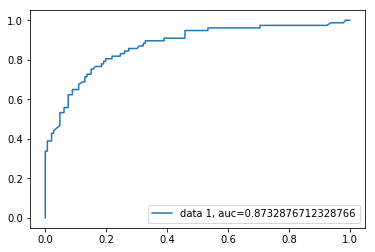

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

y_pred = model.predict(xgb.DMatrix(X_test))

fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [10]:
test_df = read_and_clean('../input/test.csv')

#for column in scalers:
#    scaler = scalers[column]
#    test_df[column] = scaler.transform(test_df[column].values.reshape(-1, 1))

predictions = model.predict(xgb.DMatrix(test_df[working_columns]))

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predictions
    })

submission.Survived = submission.Survived.apply(lambda x : 1 if x > 0.49 else 0)
submission.to_csv('submission.csv', index=False)

In [11]:
submission.head(25)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,0
9,901,0
